# Business Objective
We want to develop a recommendation system catered to the needs of the users, while still being profitable for our business. In our minds, this goal of catering to our users, though not exactly the same, is very hightly correlated with the goal of being a profitable business. If we provide better recommendations, more users will want to come to our website for getting recommendations. Further, the existing users will continue to use our website for their recommendations. If we simply recommend the most popular movies, there will be no novelty, and users would not have any reason to choose our website over another. Hence, we want to make personliazed recommendations, and achieve a high acuraccy for our recommendations. 

# TODO:
1. Sampling from large data set for prototype
2. Writeup

In [1]:
# Importing Libraries
import os
%matplotlib inline

import gc
gc.collect()


import warnings
warnings.simplefilter('ignore')

# Loading custom built functions
from model.nearest_neighbor_model import KNN
from model.lightfm_model import lightfm_model
from model.baseline_model import baseline_bias_model
from model.als_model import get_best_rank, cross_validation, plot_performance_als, get_best_sample_size
from utils.data_loader import load_spark_df, load_pandas_df, spark_to_sparse
from utils.sample_df import random_sample, sample_df_threshold, sample_popular_df, sample_df_threshold_use_pandas

from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder
from surprise.prediction_algorithms.knns import KNNWithZScore

## 1. Loading Data 

We implement a function to cache and load the dataframe from secondary memory to reduce data load time

In [2]:
# Setting Directory path
base_path = os.getcwd()
dir_name = 'ml-20m'
CACHE_DIR = base_path + '/cache/'
DATA_DIR =  base_path + '/data/'

# Loading the Data Frames
ratings_pandas_df = load_pandas_df(dir_name=dir_name, 
                                 file_name='ratings', 
                                 use_cache=True,
                                 DATA_DIR=DATA_DIR,
                                 CACHE_DIR=CACHE_DIR)

print('\nSampling DataFrame ...')
ratings_spark_df = sample_df_threshold_use_pandas(ratings_pandas_df, 
                                                  n=10**5, 
                                                  min_user_threshold=5, 
                                                  min_item_threshold=5,
                                                  quite=False
                                                 )

Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-20m_ratings.msgpack

Sampling DataFrame ...
Length before sampling: 20000263
Length after thresholding: 19912386
Length after sampling: 100000


There are a number of ways we could sample our data. In particular, we implemented and tested 3 sampling methods:

The first is raw random sampling, where we simply select a random sample of our data. It is a simple samplin g method, however, we found that it doesn't work well in practice, as we have no thresholding criteria - So by selecting random rows, we are not fine tuning the kind of users, or movies (popular or unpopuolar) we want to sample. Had the users and movies been uniformaly distributed, this would have been okay. But, we see that in our data set, the kinds of users and movies show a lot of hetrogenity, with the number of movies rated by each user, as well as the number of times each movie was rated, varying a lot across users. Therefore, we moved on to more sophisticated sampling technique

In the second sampling technique, we first selected a subset of the data based on a threshold. So we initially removed any user who had rated less than 'x' items, as well as any movie which had been rated less than 'y' times. We set x and y to 5. After getting the initial thresholded dataset, we then randomly sampled a 100000 rows. 

In the third technique, we first selected the rows with the top 'a' users, and the rows with the top 'b' movies. After getting those 2 datasets, we performed an inner merge to include only users which are in the top 'a', and movies which are in the top 'b'. From this merged dataset containing the most popular users and movies, we then sampled a fraction of the rows for our final sampled dataset.

Having tried all these sampling methods (detailed code in utils/sample.py), we selected method 2 as our final sampling technique. This was because choosing all users/movies abive a certain threshold was more in line with our final objective of building a recommendation system which caters to the needs of everyone, not just users who rate a lot of movies.

## 2. Analysis of methods

### 2.1 Baseline Method: Bias based model

We first fit a bias only model to the data to set a benchmark for baseline model. 

In [5]:
%%time

baseline_bias_model(ratings_spark_df)

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9599  0.9563  0.9627  0.9559  0.9615  0.9593  0.0027  
MAE (testset)     0.7495  0.7453  0.7477  0.7440  0.7505  0.7474  0.0024  
Fit time          0.12    0.12    0.17    0.12    0.12    0.13    0.02    
Test time         0.09    0.10    0.13    0.11    0.09    0.10    0.01    


CPU times: user 9.03 s, sys: 149 ms, total: 9.18 s
Wall time: 9.86 s


### 2.2 Model based method using Alternating Least Squares method

We build a Matrix Factorization model using ALS method, and iterate over different rank ranges to find the optimal rank

#### 2.2.1 Finding best hyperparameter setting using cross validation

In [4]:
%%time
gc.collect()

# Creating a Parameter Grid for ALS
model = ALS(userCol="userId",
                  itemCol="movieId",
                  ratingCol="rating",
                  coldStartStrategy="drop",
                  nonnegative=True)

paramGrid = ParamGridBuilder() \
            .addGrid(model.maxIter, [3]) \
            .addGrid(model.regParam, [0.01,0.1]) \
            .addGrid(model.rank, [64, 128]) \
            .build()

# Finding best parameter combination from cross validation
best_hyper_parameter, best_model = cross_validation(ratings_spark_df, 
                                                     model=model, 
                                                     evaluator='Regression', 
                                                     param_grid=paramGrid, 
                                                     k_folds=3)

print("Best Hyper-parameter combination for ALS Model:")
display(best_hyper_parameter)
print('\n')

RMSE of Best Model on Test Set: 1.6045
Best Hyper-parameter combination for ALS Model:


,HyperParameter,Value
0,maxIter,3
1,regParam,0.1
2,rank,64




CPU times: user 831 ms, sys: 211 ms, total: 1.04 s
Wall time: 2min 10s


#### 2.1.2 For different ranks, plotting RMSE and coverage on training and test set

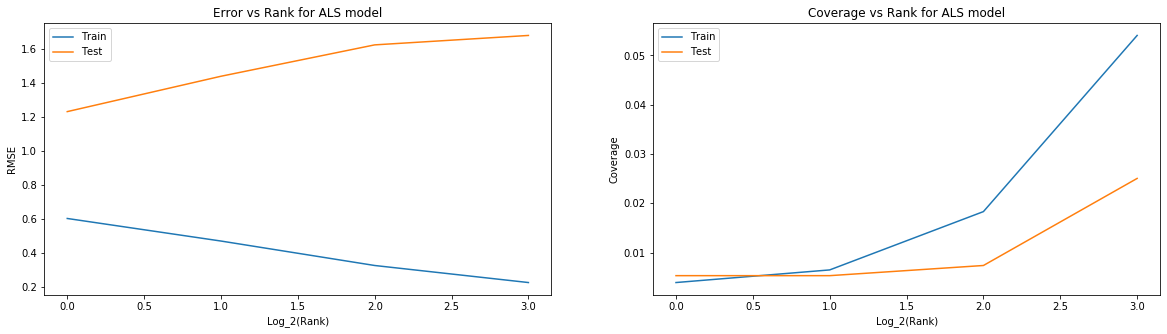

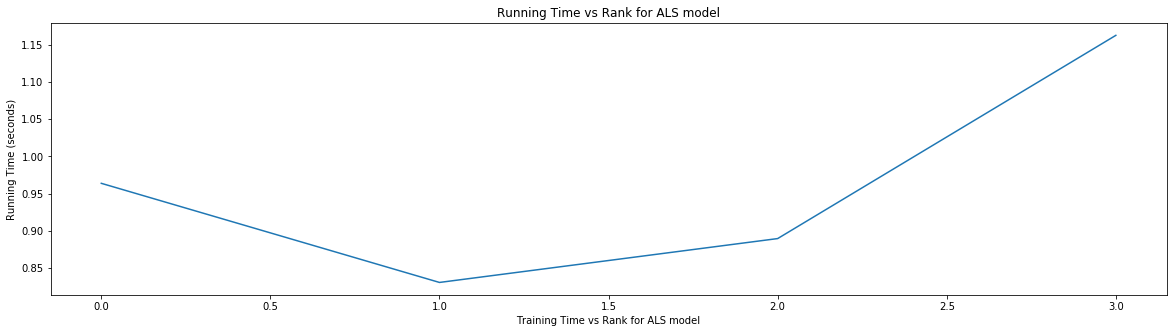

,Rank,RMSE_train,RMSE_test,Coverage_train,Coverage_test,Running_time
0,1.0,0.602029,1.232511,0.003906,0.005303,0.963899
1,2.0,0.468891,1.441148,0.006469,0.005303,0.830599
2,4.0,0.324589,1.626286,0.018308,0.007366,0.889599
3,8.0,0.224033,1.681911,0.054071,0.025044,1.162878




CPU times: user 1.11 s, sys: 250 ms, total: 1.36 s
Wall time: 59.1 s


In [6]:
%%time
gc.collect()

pow_two_max_rank = 3

ranks = [2**i for i in range(pow_two_max_rank+1)]

report_df = get_best_rank(ratings_spark_df, ranks=ranks)

plot_performance_als(report_df)
display(report_df)
print('\n')

We observe the following:
1. The training error keeps on decreasing with increased rank, but the test error shows no significant improvement indicating signs of overfitting
2. The coverage of items improves with respect to rank
3. The time to fit the model takes expontially higher time in correlation with rank

Note: We use Catalog Coverage to take into account the number of unique movies that were recommended to atleast one user as a top choice amongst the set of all unique movies.

#### 2.1.3 For diffrent sizes, plotting RMSE and coverage on training and test set

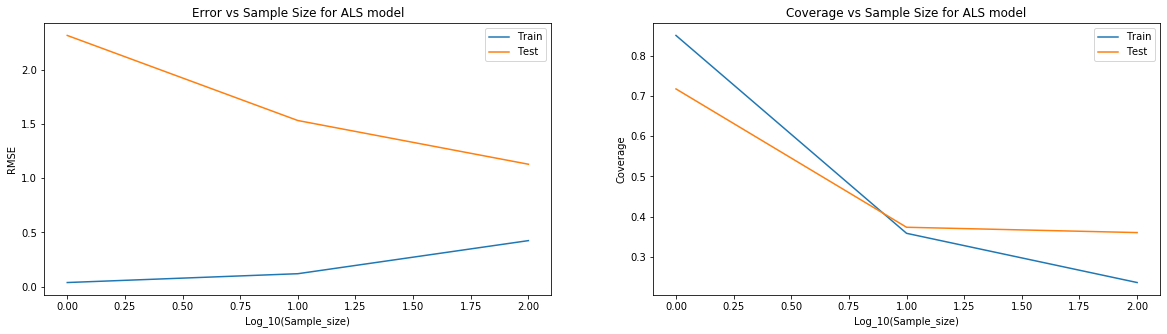

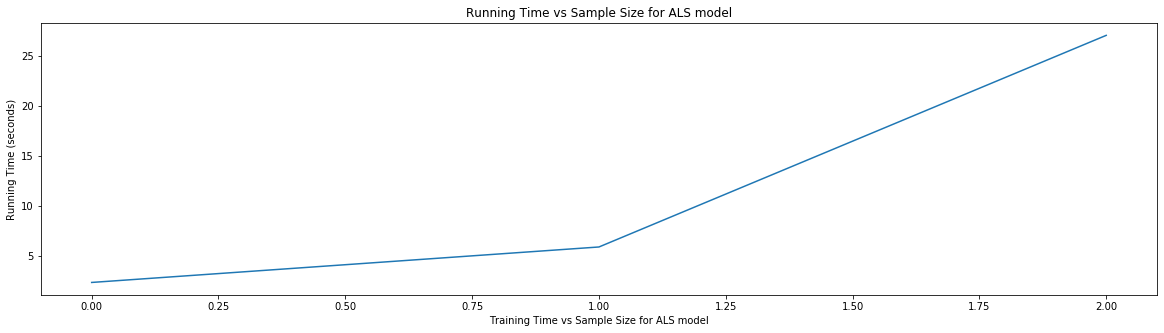

,Sample_size,RMSE_train,RMSE_test,Coverage_train,Coverage_test,Running_time
0,10000.0,0.038416,2.315028,0.851130,0.717916,2.378299
1,100000.0,0.119725,1.531219,0.358233,0.373306,5.913961
2,1000000.0,0.424621,1.128426,0.235614,0.360080,27.011153




CPU times: user 28.2 s, sys: 609 ms, total: 28.8 s
Wall time: 2min 37s


In [3]:
%%time
gc.collect()

sample_size = [10**i for i in range(4,7)]

report_df = get_best_sample_size(ratings_pandas_df, 
                                 sample_size = sample_size)

plot_performance_als(report_df, report_type='sample')
display(report_df)
print('\n')

### 2.3 LightFM:

We use LightFM model to find how it performs over over dataset

In [11]:
%%time
gc.collect()

sparse_mat = spark_to_sparse(ratings_spark_df)
lightfm_model(sparse_mat, prec_at_k=10, train_split=0.8)

MemoryError: Unable to allocate array with shape (138484, 112853) and data type float64

### 2.4. Neighborhood based method using Nearest Neighbor

We use Nearest Neighbor algorithm with z-score normalization of each user

In [12]:
%%time
gc.collect()

# Defining parameters for Nearest Neighbor model
sim_options = {'name': 'cosine',
               'user_based': True
               }
model = KNNWithZScore(sim_options=sim_options)

KNN(model=model, df=ratings_spark_df)

Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1011  1.1220  0.9836  1.0691  1.0588  1.0669  0.0474  
MAE (testset)     0.8851  0.8812  0.8098  0.8304  0.8471  0.8507  0.0290  
Fit time          0.04    0.04    0.04    0.05    0.06    0.05    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


CPU times: user 199 ms, sys: 3.85 ms, total: 202 ms
Wall time: 544 ms


#### We observe that the Baseline Bias model performs quite well, and other more sophesiticated models (except lightFM) don't yield significant improvments over it hence the Bias model might be the most suited for production

#### We observe that LightFm model has high AUC, meaning it is producing quantifiably quality results.

# Conclusions

Our recommendation system is doing a fairly good job in terms of our metrics - low RMSE, fairly high coverage. There is still room for improvement, though. #Add to this